In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

import sys

sys.path.append("../")

from src.envs import RLFSEnvSparse
from src.rl import REINFORCE
from src.errors import sammon_error

In [159]:
INF_LOOP_CNT = 5

In [160]:
def get_data_frames(train_path, test_path):
    data_train = pd.read_csv(train_path, sep=",")
    data_test = pd.read_csv(test_path, sep=",")

    return data_train, data_test


def get_data_train_test(data_train, data_test):
    X_train = data_train.drop(columns=["repository"], inplace=False)
    X_train = X_train.to_numpy()

    X_test = data_test.drop(columns=["repository"], inplace=False)
    X_test = X_test.to_numpy()

    return X_train, X_test

def powers_of_two_less_than(n):
    max_exponent = int(np.log2(n))  # Find the largest exponent such that 2^k < N
    return 2 ** np.arange(max_exponent+1)

In [161]:
def train_reinforce_agent(X_train, agent, device, make_plots=False):
    state_space = X_train.shape[1]
    action_space = X_train.shape[1]
    for i, num_features in enumerate(powers_of_two_less_than(state_space//2)):
            env = RLFSEnvSparse(
                state_size=state_space, data=X_train, max_features=num_features
            )
            print(f"Iteration {i}, Number of features {num_features}")
            episode_returns = agent.train(
                env=env,
                num_episodes=1000 + 1500 // (i+1),
                max_steps=num_features,
            )
            # torch.save(agent.policy.state_dict(), "models/REINFORCE/policy_weights.pth")
            if make_plots:
                plt.plot(episode_returns)
                plt.show()

In [179]:
def test_agent(X_test, data_test, agent, verbose=True):
    state_space = X_test.shape[1]
    action_space = X_test.shape[1]
    env = RLFSEnvSparse(state_size=state_space, data=X_test, max_features=state_space)
    errors = []
    num_ftrs = []
    selected_features = []
    if verbose:
        print("waiting...")
    for n in range(0, state_space+1):
        state = env.reset()
        # errors.append(sammon_error(X_test, state))
        state_cnt = 0  # int(np.sum(state))
        done = False
        # if verbose:
        #     print(f"n={n}")
        inf_loop_cnt = INF_LOOP_CNT
        action_sequence = []
        while state_cnt < n and not done:
            if inf_loop_cnt > 0:
                action, action_prob = agent.select_action_deterministic(state)
            else:
                # print("+")
                action, action_prob = agent.select_action(state)
                # print(np.exp(action_prob.detach().numpy()))

            next_state, _, done, _ = env.step(action)
            action_sequence.append(action)

            if int(np.sum(next_state)) > state_cnt:
                # print(state_cnt)
                inf_loop_cnt = INF_LOOP_CNT
                state_cnt = int(np.sum(next_state))
            else:
                inf_loop_cnt -= 1

            state = next_state
        # print(np.sum(state))
        error = sammon_error(X_test, state)
        errors.append(error)
        num_ftrs.append(n)
        selected_features.append(
            [data_test.drop(columns=["repository"]).columns[action] for action in action_sequence]
        )

    return errors, num_ftrs, selected_features

In [180]:
train_path_class = "../data/data_class_train.csv"
test_path_class = "../data/data_class.csv"
train_path_method = "../data/data_method_train.csv"
test_path_method = "../data/data_method.csv"

In [181]:
data_train_method, data_test_method = get_data_frames(train_path_method, test_path_method)
X_train_method, X_test_method = get_data_train_test(data_train_method, data_test_method)
state_space_method = X_train_method.shape[1]
action_space_method = X_train_method.shape[1]

data_train_class, data_test_class = get_data_frames(train_path_class, test_path_class)
X_train_class, X_test_class = get_data_train_test(data_train_class, data_test_class)
state_space_class = X_train_class.shape[1]
action_space_class = X_train_class.shape[1]

In [182]:
data_train_method.shape, data_test_method.shape

((95, 22), (106, 22))

In [183]:
data_train_class.shape, data_test_class.shape

((115, 22), (128, 22))

In [184]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
agent = REINFORCE.REINFORCEAgent(state_space_method, action_space_method, gamma=1, lr=0.0001)

In [185]:
def run_train_test(X_train, X_test, data_test, agent, device):
    train_reinforce_agent(X_train, agent, device)
    return test_agent(X_test, data_test, agent)

In [186]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [187]:
agent_method = REINFORCE.REINFORCEAgent(
    state_space_method, action_space_method, gamma=1, lr=0.0001
)
errors, num_ftrs, selected_features = run_train_test(
    X_train=X_train_method,
    X_test=X_test_method,
    data_test=data_test_method,
    agent=agent_method,
    device=device,
)

print(selected_features)


Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 2500/2500 [00:03<00:00, 650.64it/s, LR=6.05e-5, Return=0.0731]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1750/1750 [00:02<00:00, 633.23it/s, LR=4.26e-5, Return=0.282]  


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 1500/1500 [00:03<00:00, 441.71it/s, LR=3.15e-5, Return=0.99]  


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 1375/1375 [00:04<00:00, 291.33it/s, LR=2.4e-5, Return=0.384]  


waiting...
[[], ['HEFF'], ['HEFF', 'HVOL'], ['HEFF', 'HVOL', 'MI'], ['HEFF', 'HVOL', 'MI', 'HCPL'], ['HEFF', 'HVOL', 'MI', 'HCPL', 'HTRP'], ['HEFF', 'HVOL', 'MI', 'HCPL', 'HTRP', 'LOC'], ['HEFF', 'HVOL', 'MI', 'HCPL', 'HTRP', 'LOC', 'HPL'], ['HEFF', 'HVOL', 'MI', 'HCPL', 'HTRP', 'LOC', 'HPL', 'TLOC'], ['HEFF', 'HVOL', 'MI', 'HCPL', 'HTRP', 'LOC', 'HPL', 'TLOC', 'TLLOC'], ['HEFF', 'HVOL', 'MI', 'HCPL', 'HTRP', 'LOC', 'HPL', 'TLOC', 'TLLOC', 'LLOC'], ['HEFF', 'HVOL', 'MI', 'HCPL', 'HTRP', 'LOC', 'HPL', 'TLOC', 'TLLOC', 'LLOC', 'NOS'], ['HEFF', 'HVOL', 'MI', 'HCPL', 'HTRP', 'LOC', 'HPL', 'TLOC', 'TLLOC', 'LLOC', 'NOS', 'CLOC'], ['HEFF', 'HVOL', 'MI', 'HCPL', 'HTRP', 'LOC', 'HPL', 'TLOC', 'TLLOC', 'LLOC', 'NOS', 'CLOC', 'HPV'], ['HEFF', 'HVOL', 'MI', 'HCPL', 'HTRP', 'LOC', 'HPL', 'TLOC', 'TLLOC', 'LLOC', 'NOS', 'CLOC', 'HPV', 'TNOS'], ['HEFF', 'HVOL', 'MI', 'HCPL', 'HTRP', 'LOC', 'HPL', 'TLOC', 'TLLOC', 'LLOC', 'NOS', 'CLOC', 'HPV', 'TNOS', 'DLOC'], ['HEFF', 'HVOL', 'MI', 'HCPL', 'HTRP', '

In [188]:
selected_features_ = ['']
selected_features_.extend(selected_features[-1])

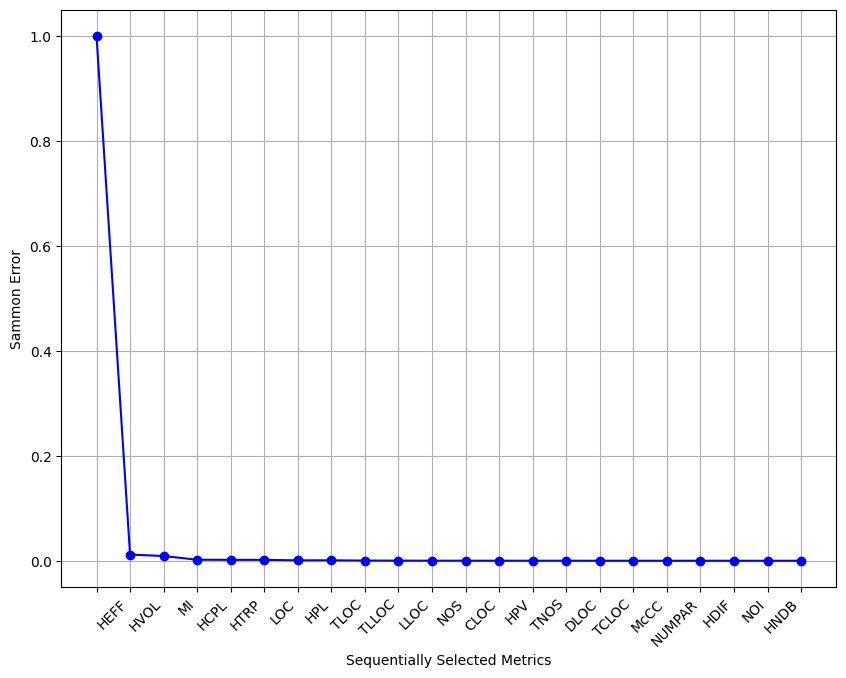

In [189]:
# Plot
plt.figure(figsize=(10, 7.5))
plt.plot(num_ftrs, errors, marker='o', linestyle='-', color='b')
plt.xlabel('Sequentially Selected Metrics')
plt.ylabel('Sammon Error')
# plt.title('Sammon Error vs Number of Features')
plt.xticks(num_ftrs, selected_features_, rotation=45, ha='right')  # Map indices to feature names
plt.grid(True)
plt.show()

In [190]:
agent_class = REINFORCE.REINFORCEAgent(
    state_space_class, action_space_class, gamma=1, lr=0.0001
)
errors, num_ftrs, selected_features = run_train_test(
    X_train=X_train_class,
    X_test=X_test_class,
    data_test=data_test_class,
    agent=agent_class,
    device=device,
)

Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 2500/2500 [00:03<00:00, 666.86it/s, LR=6.05e-5, Return=0.133]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1750/1750 [00:03<00:00, 516.98it/s, LR=4.26e-5, Return=0.647]  


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 1500/1500 [00:03<00:00, 416.82it/s, LR=3.15e-5, Return=0.467]  


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 1375/1375 [00:04<00:00, 276.67it/s, LR=2.4e-5, Return=0.811] 


waiting...


In [191]:
selected_features_ = ['']
selected_features_.extend(selected_features[-1])

In [206]:
print(selected_features_)

['', 'TLLOC', 'TLOC', 'LOC', 'LLOC', 'TNOS', 'NOS', 'CLOC', 'WMC', 'TNM', 'NM', 'RFC', 'TNLM', 'NLM', 'LCOM5', 'NOA', 'DIT', 'NOI', 'NOD', 'NOC', 'NOP', 'CBO']


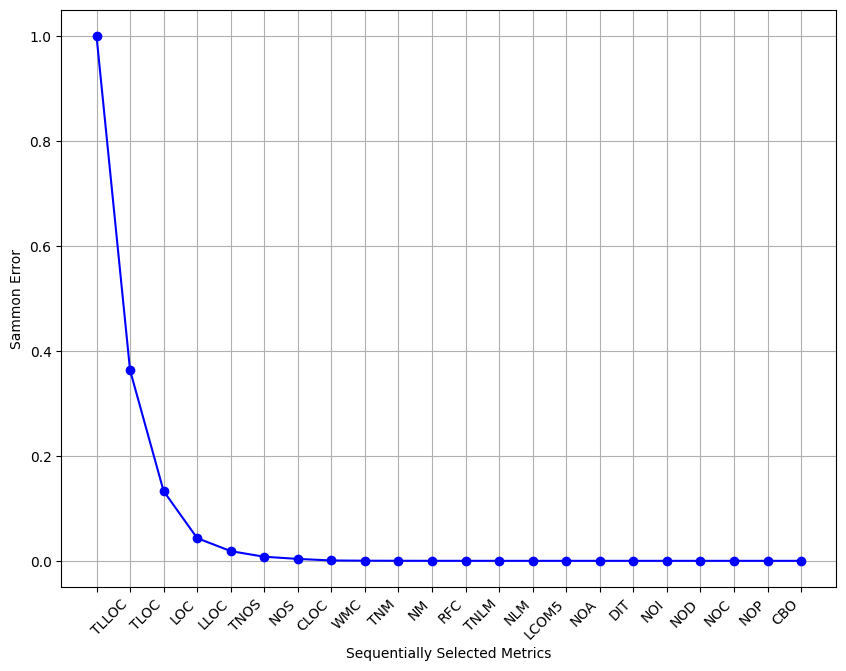

In [192]:
# Plot
plt.figure(figsize=(10, 7.5))
plt.plot(num_ftrs, errors, marker='o', linestyle='-', color='b')
plt.xlabel('Sequentially Selected Metrics')
plt.ylabel('Sammon Error')
# plt.title('Sammon Error vs Number of Features')
plt.xticks(num_ftrs, selected_features_, rotation=45, ha='right')  # Map indices to feature names
plt.grid(True)
plt.show()

In [193]:
def test_stability(X_train, X_test, data_test, num_iters=10):
    state_space = X_train.shape[1]
    action_space = X_train.shape[1]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    all_errors = []
    all_num_ftrs = []
    all_selected_features = []
    for i in range(num_iters):
        agent = REINFORCE.REINFORCEAgent(state_space, action_space, gamma=1, lr=0.0001)
        errors, num_ftrs, selected_features = run_train_test(
            X_train, X_test, data_test, agent, device
        )
        all_errors.append(errors)
        all_num_ftrs.append(num_ftrs)
        all_selected_features.append(selected_features)

    return all_errors, all_num_ftrs, all_selected_features

In [194]:
all_errors, all_num_ftrs, all_selected_features = test_stability(X_train_class, X_test_class, data_test_class, num_iters=10)

Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 2500/2500 [00:03<00:00, 642.41it/s, LR=6.05e-5, Return=0.28]   


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1750/1750 [00:02<00:00, 589.34it/s, LR=4.26e-5, Return=0.658]  


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 1500/1500 [00:04<00:00, 371.55it/s, LR=3.15e-5, Return=0.85]   


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 1375/1375 [00:04<00:00, 287.66it/s, LR=2.4e-5, Return=0.725]  


waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 2500/2500 [00:03<00:00, 664.44it/s, LR=6.05e-5, Return=0.047]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1750/1750 [00:03<00:00, 557.26it/s, LR=4.26e-5, Return=0.743]  


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 1500/1500 [00:03<00:00, 415.97it/s, LR=3.15e-5, Return=0.304] 


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 1375/1375 [00:04<00:00, 276.20it/s, LR=2.4e-5, Return=0.962] 


waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 2500/2500 [00:03<00:00, 705.01it/s, LR=6.05e-5, Return=0.742]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1750/1750 [00:03<00:00, 567.72it/s, LR=4.26e-5, Return=0.336]  


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 1500/1500 [00:03<00:00, 409.08it/s, LR=3.15e-5, Return=0.744] 


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 1375/1375 [00:05<00:00, 273.43it/s, LR=2.4e-5, Return=0.97]   


waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 2500/2500 [00:03<00:00, 710.70it/s, LR=6.05e-5, Return=0.00407]


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1750/1750 [00:03<00:00, 548.72it/s, LR=4.26e-5, Return=0.0327] 


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 1500/1500 [00:04<00:00, 318.61it/s, LR=3.15e-5, Return=0.749]  


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 1375/1375 [00:05<00:00, 264.88it/s, LR=2.4e-5, Return=0.899] 


waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 2500/2500 [00:03<00:00, 653.76it/s, LR=6.05e-5, Return=0.743]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1750/1750 [00:03<00:00, 511.13it/s, LR=4.26e-5, Return=0.159]  


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 1500/1500 [00:04<00:00, 301.02it/s, LR=3.15e-5, Return=0.721]  


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 1375/1375 [00:05<00:00, 250.16it/s, LR=2.4e-5, Return=0.997] 


waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 2500/2500 [00:04<00:00, 549.29it/s, LR=6.05e-5, Return=0.0443] 


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1750/1750 [00:03<00:00, 506.57it/s, LR=4.26e-5, Return=0.334]  


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 1500/1500 [00:04<00:00, 370.81it/s, LR=3.15e-5, Return=0.71]   


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 1375/1375 [00:05<00:00, 248.94it/s, LR=2.4e-5, Return=0.725] 


waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 2500/2500 [00:06<00:00, 393.57it/s, LR=6.05e-5, Return=0.0054] 


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1750/1750 [00:03<00:00, 571.37it/s, LR=4.26e-5, Return=0.0452] 


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 1500/1500 [00:03<00:00, 445.06it/s, LR=3.15e-5, Return=0.792]  


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 1375/1375 [00:05<00:00, 243.72it/s, LR=2.4e-5, Return=0.9]    


waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 2500/2500 [00:04<00:00, 587.73it/s, LR=6.05e-5, Return=0.133]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1750/1750 [00:03<00:00, 516.94it/s, LR=4.26e-5, Return=0.743]  


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 1500/1500 [00:03<00:00, 377.13it/s, LR=3.15e-5, Return=0.658]  


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 1375/1375 [00:05<00:00, 231.86it/s, LR=2.4e-5, Return=0.83]  


waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 2500/2500 [00:04<00:00, 580.18it/s, LR=6.05e-5, Return=0.743]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1750/1750 [00:03<00:00, 492.13it/s, LR=4.26e-5, Return=0.28]   


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 1500/1500 [00:04<00:00, 372.10it/s, LR=3.15e-5, Return=0.336] 


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 1375/1375 [00:05<00:00, 247.70it/s, LR=2.4e-5, Return=0.96]  


waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 2500/2500 [00:03<00:00, 639.11it/s, LR=6.05e-5, Return=0.331]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1750/1750 [00:03<00:00, 461.07it/s, LR=4.26e-5, Return=0.64]   


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 1500/1500 [00:05<00:00, 280.28it/s, LR=3.15e-5, Return=0.748]  


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 1375/1375 [00:05<00:00, 251.51it/s, LR=2.4e-5, Return=0.919]  


waiting...


In [195]:
min_errors = np.min(all_errors, axis=0)
max_errors = np.max(all_errors, axis=0)
avg_errors = np.mean(all_errors, axis=0)
min_errors, max_errors, avg_errors

(array([1.00000000e+00, 2.57124478e-01, 9.75449645e-02, 4.31939462e-02,
        1.85016886e-02, 7.79003105e-03, 3.19280335e-03, 6.63314552e-04,
        2.65971245e-04, 9.46305014e-05, 3.24146997e-05, 1.60601882e-05,
        6.02744665e-06, 1.14528182e-06, 5.72780123e-08, 3.72281631e-08,
        2.35848481e-08, 1.38335292e-08, 7.04180356e-09, 2.36596298e-09,
        5.91032200e-10, 1.99403505e-20]),
 array([1.00000000e+00, 3.63028417e-01, 1.32897849e-01, 6.60057136e-02,
        1.85016886e-02, 1.05866600e-02, 3.67713718e-03, 6.63314552e-04,
        2.65971245e-04, 1.01616929e-04, 3.24146997e-05, 1.66208819e-05,
        6.37066061e-06, 2.60750098e-06, 5.72780123e-08, 4.72225426e-08,
        3.83307719e-08, 2.95432942e-08, 1.81680521e-08, 9.71084062e-09,
        4.75080787e-09, 1.99403505e-20]),
 array([1.00000000e+00, 2.68106199e-01, 1.25682132e-01, 5.46321257e-02,
        1.85016886e-02, 8.07619947e-03, 3.58027041e-03, 6.63314552e-04,
        2.65971245e-04, 9.74250724e-05, 3.24146997e-

In [196]:
df_reinforce_class = pd.DataFrame({
    "number_of_features": all_num_ftrs[0],
    "min_error": min_errors,
    "max_error": max_errors,
    "avg_error": avg_errors
})
df_reinforce_class

,number_of_features,min_error,max_error,avg_error
0,0,1.000000e+00,1.000000e+00,1.000000e+00
1,1,2.571245e-01,3.630284e-01,2.681062e-01
2,2,9.754496e-02,1.328978e-01,1.256821e-01
3,3,4.319395e-02,6.600571e-02,5.463213e-02
4,4,1.850169e-02,1.850169e-02,1.850169e-02
5,5,7.790031e-03,1.058666e-02,8.076199e-03
6,6,3.192803e-03,3.677137e-03,3.580270e-03
7,7,6.633146e-04,6.633146e-04,6.633146e-04
8,8,2.659712e-04,2.659712e-04,2.659712e-04
9,9,9.463050e-05,1.016169e-04,9.742507e-05


In [197]:
df_reinforce_class.to_csv("../data/results/REINFORCE_class.csv", index=False)

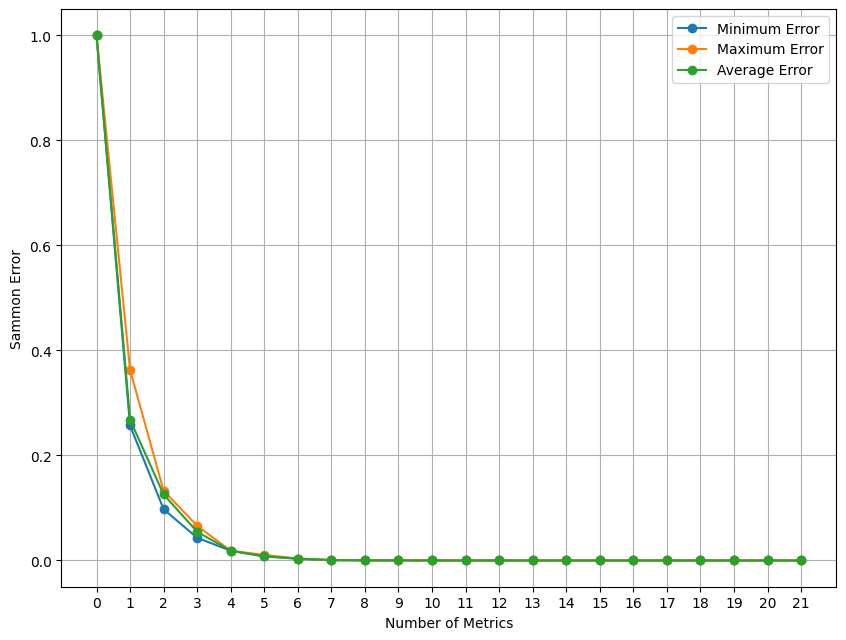

In [198]:
# Plot
plt.figure(figsize=(10, 7.5))
plt.plot(all_num_ftrs[0], min_errors, marker='o', label='Minimum Error')
plt.plot(all_num_ftrs[0], max_errors, marker='o', label='Maximum Error')
plt.plot(all_num_ftrs[0], avg_errors, marker='o', label='Average Error')

# Add plot details
plt.xlabel('Number of Metrics')
plt.ylabel('Sammon Error')
# plt.title('Model Stability across Retrainings')
plt.xticks(all_num_ftrs[0])  # Ensure x-axis ticks are integers from all_num_ftrs
plt.legend()
plt.grid(True)
plt.show()

In [199]:
all_errors_m, all_num_ftrs_m, all_selected_features_m = test_stability(X_train_method, X_test_method, data_test_method, num_iters=10)

Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 2500/2500 [00:03<00:00, 804.42it/s, LR=6.05e-5, Return=0.103]   


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1750/1750 [00:02<00:00, 764.86it/s, LR=4.26e-5, Return=0.0274] 


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 1500/1500 [00:02<00:00, 545.35it/s, LR=3.15e-5, Return=0.188] 


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 1375/1375 [00:04<00:00, 332.86it/s, LR=2.4e-5, Return=0.238]  


waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 2500/2500 [00:02<00:00, 878.64it/s, LR=6.05e-5, Return=0.0293]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1750/1750 [00:02<00:00, 729.52it/s, LR=4.26e-5, Return=0.103]  


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 1500/1500 [00:02<00:00, 509.20it/s, LR=3.15e-5, Return=0.102] 


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 1375/1375 [00:04<00:00, 327.39it/s, LR=2.4e-5, Return=0.998] 


waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 2500/2500 [00:03<00:00, 826.38it/s, LR=6.05e-5, Return=0.987]   


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1750/1750 [00:02<00:00, 587.62it/s, LR=4.26e-5, Return=0.0678] 


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 1500/1500 [00:03<00:00, 413.71it/s, LR=3.15e-5, Return=0.295] 


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 1375/1375 [00:04<00:00, 300.63it/s, LR=2.4e-5, Return=0.311] 


waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 2500/2500 [00:03<00:00, 791.22it/s, LR=6.05e-5, Return=0.0293]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1750/1750 [00:02<00:00, 646.84it/s, LR=4.26e-5, Return=0.0684] 


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 1500/1500 [00:03<00:00, 455.25it/s, LR=3.15e-5, Return=0.287] 


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 1375/1375 [00:04<00:00, 314.41it/s, LR=2.4e-5, Return=0.12]  


waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 2500/2500 [00:03<00:00, 784.31it/s, LR=6.05e-5, Return=0.0554]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1750/1750 [00:02<00:00, 641.24it/s, LR=4.26e-5, Return=0.177]  


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 1500/1500 [00:03<00:00, 404.44it/s, LR=3.15e-5, Return=0.101] 


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 1375/1375 [00:04<00:00, 284.90it/s, LR=2.4e-5, Return=0.991]  


waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 2500/2500 [00:03<00:00, 749.48it/s, LR=6.05e-5, Return=0.278]   


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1750/1750 [00:03<00:00, 571.06it/s, LR=4.26e-5, Return=0.0343] 


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 1500/1500 [00:03<00:00, 438.71it/s, LR=3.15e-5, Return=0.171] 


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 1375/1375 [00:04<00:00, 306.39it/s, LR=2.4e-5, Return=0.993]  


waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 2500/2500 [00:03<00:00, 787.18it/s, LR=6.05e-5, Return=0.0333]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1750/1750 [00:03<00:00, 577.31it/s, LR=4.26e-5, Return=0.0568] 


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 1500/1500 [00:03<00:00, 452.59it/s, LR=3.15e-5, Return=0.0942]


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 1375/1375 [00:04<00:00, 300.23it/s, LR=2.4e-5, Return=0.205]  


waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 2500/2500 [00:03<00:00, 751.62it/s, LR=6.05e-5, Return=0.0554]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1750/1750 [00:02<00:00, 619.41it/s, LR=4.26e-5, Return=0.103]  


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 1500/1500 [00:03<00:00, 431.84it/s, LR=3.15e-5, Return=0.357] 


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 1375/1375 [00:04<00:00, 307.67it/s, LR=2.4e-5, Return=0.221]  


waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 2500/2500 [00:03<00:00, 784.44it/s, LR=6.05e-5, Return=0.00194] 


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1750/1750 [00:03<00:00, 475.95it/s, LR=4.26e-5, Return=0.081]  


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 1500/1500 [00:03<00:00, 408.80it/s, LR=3.15e-5, Return=0.99]  


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 1375/1375 [00:04<00:00, 289.62it/s, LR=2.4e-5, Return=0.998] 


waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 2500/2500 [00:03<00:00, 817.14it/s, LR=6.05e-5, Return=0.0293]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1750/1750 [00:03<00:00, 486.70it/s, LR=4.26e-5, Return=0.279]  


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 1500/1500 [00:03<00:00, 411.80it/s, LR=3.15e-5, Return=0.365] 


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 1375/1375 [00:04<00:00, 304.75it/s, LR=2.4e-5, Return=0.993] 


waiting...


In [200]:
print(all_selected_features[0][-1])
print([float(error) for error in all_errors[0]])

['TLOC', 'TLLOC', 'LOC', 'LLOC', 'NOS', 'TNOS', 'CLOC', 'WMC', 'TNM', 'NM', 'RFC', 'TNLM', 'NLM', 'LCOM5', 'CBO', 'NOD', 'DIT', 'NOA', 'NOP', 'NOC', 'NOI']
[1.0, 0.25777669026353045, 0.13289784889806994, 0.043274685773930927, 0.018501688577998953, 0.0078062948581504085, 0.0036771371790677654, 0.000663314552224087, 0.0002659712453194879, 9.463050136472389e-05, 3.2414699660032376e-05, 1.6060188221672594e-05, 6.027446646989955e-06, 1.1452818178649029e-06, 5.727801231650618e-08, 3.722816305426973e-08, 2.358484810355988e-08, 1.3833529223584074e-08, 7.041803559078737e-09, 4.637668221422797e-09, 3.4181870390809513e-09, 1.99403504986271e-20]


In [201]:
print(all_selected_features_m[0][-1])
print([float(error) for error in all_errors_m[0]])

['HEFF', 'HVOL', 'MI', 'HCPL', 'HTRP', 'LOC', 'TLOC', 'TLLOC', 'LLOC', 'HPL', 'TNOS', 'NOS', 'TCLOC', 'HPV', 'DLOC', 'CLOC', 'McCC', 'NOI', 'NUMPAR', 'HDIF', 'HNDB']
[1.0, 0.011813886698870594, 0.009016885786702365, 0.0019596797875874477, 0.0017440825400036667, 0.0017211518924381128, 0.0008639300895711715, 0.0003956875744888608, 0.00023038280405010263, 0.00015375953289815947, 0.00014554414849045696, 0.00013087085072888867, 0.00011941868095530517, 5.1504648019695304e-05, 4.9681660390780385e-05, 1.2225516802819439e-05, 5.155867740509122e-07, 4.071580721459272e-07, 4.0355293476836194e-07, 9.435473991276468e-11, 4.170330986079913e-18, 1.3786943288452742e-20]


In [202]:
min_errors = np.min(all_errors_m, axis=0)
max_errors = np.max(all_errors_m, axis=0)
avg_errors = np.mean(all_errors_m, axis=0)
min_errors, max_errors, avg_errors

(array([1.00000000e+00, 1.18138867e-02, 9.01688579e-03, 1.95967979e-03,
        1.74408254e-03, 1.72115189e-03, 8.59628964e-04, 3.95687574e-04,
        2.30382804e-04, 1.53759533e-04, 1.45544148e-04, 6.95341815e-05,
        5.80399487e-05, 5.00693742e-05, 1.31887714e-05, 2.05304730e-06,
        5.15586774e-07, 7.21470572e-08, 3.00812035e-10, 9.43547399e-11,
        4.17033099e-18, 1.37869433e-20]),
 array([1.00000000e+00, 1.18138867e-02, 9.01688579e-03, 8.46290479e-03,
        1.92779415e-03, 1.72115189e-03, 8.63930090e-04, 3.95687574e-04,
        3.81315531e-04, 2.22450800e-04, 1.45544148e-04, 1.41953698e-04,
        1.28218164e-04, 1.16652675e-04, 4.96816604e-05, 1.28578336e-05,
        5.15586774e-07, 4.07158072e-07, 4.07157715e-07, 3.00777918e-10,
        1.41241281e-10, 1.37869433e-20]),
 array([1.00000000e+00, 1.18138867e-02, 9.01688579e-03, 2.61000229e-03,
        1.76245370e-03, 1.72115189e-03, 8.61779527e-04, 3.95687574e-04,
        2.46129176e-04, 1.94041841e-04, 1.45544148e-

In [203]:
df_reinforce_method = pd.DataFrame({
    "number_of_features": all_num_ftrs_m[0],
    "min_error": min_errors,
    "max_error": max_errors,
    "avg_error": avg_errors
})
df_reinforce_method

,number_of_features,min_error,max_error,avg_error
0,0,1.000000e+00,1.000000e+00,1.000000e+00
1,1,1.181389e-02,1.181389e-02,1.181389e-02
2,2,9.016886e-03,9.016886e-03,9.016886e-03
3,3,1.959680e-03,8.462905e-03,2.610002e-03
4,4,1.744083e-03,1.927794e-03,1.762454e-03
5,5,1.721152e-03,1.721152e-03,1.721152e-03
6,6,8.596290e-04,8.639301e-04,8.617795e-04
7,7,3.956876e-04,3.956876e-04,3.956876e-04
8,8,2.303828e-04,3.813155e-04,2.461292e-04
9,9,1.537595e-04,2.224508e-04,1.940418e-04


In [204]:
df_reinforce_method.to_csv("../data/results/REINFORCE_method.csv", index=False)

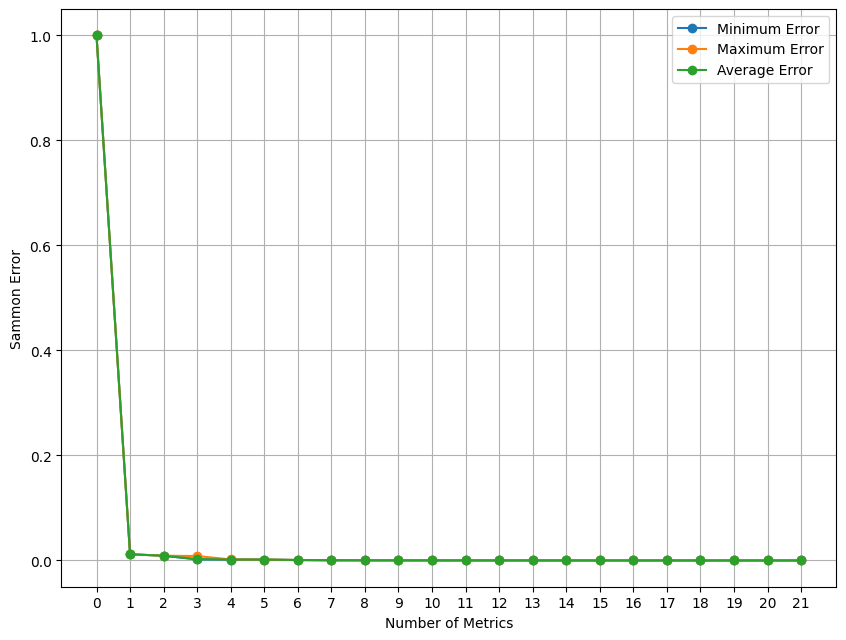

In [205]:
# Plot
plt.figure(figsize=(10, 7.5))
plt.plot(all_num_ftrs_m[0], min_errors, marker='o', label='Minimum Error')
plt.plot(all_num_ftrs_m[0], max_errors, marker='o', label='Maximum Error')
plt.plot(all_num_ftrs_m[0], avg_errors, marker='o', label='Average Error')

# Add plot details
plt.xlabel('Number of Metrics')
plt.ylabel('Sammon Error')
# plt.title('Model Stability across Retrainings')
plt.xticks(all_num_ftrs_m[0])  # Ensure x-axis ticks are integers from all_num_ftrs
plt.legend()
plt.grid(True)
plt.show()